# Overview 
This preprocessing notebook does the following:

    -Loads Post EDA Data
    -Adds three new classifier columns, in addition to the already existing SepsisLabel (1 if Sepsis, 0 if not)
        -Pre_Sepsis (3 States): 2 if in six hour pre-sepsis period
        -Pre_Acute_Sepsis (4 States): 2 if in acute pre-sepsis period (0-3 hrs), 3 if in pre-sepsis period (3-6 hrs).
        -Hourly_Sepsis indicates (8 States): 2-7 for each hour in six hour pre-sepsis period
    -Modifies Vital Signs 
        -Interploate missing values by patient, bfill if first value is missing for patient
        -No values available whatsoever for that patient and feature, then group median for that vital sign used.
    -Adds columns for changes in vitals 
        -Change since previous, two previous and three previous
        -Have prefix d1_, d2_, d3_
    -Modifies Lab Values:
        -Log transforms skewed distributions
        -Forward fill lab values per patient
        -When no lab values exist whatsoever for patient, fill with median.
    -Creates dummy variable columns indicating if lab value is present or not for patient 
        -1 from when the lab value occurs until the end of that patient's data
        -Have prefix dummy_
    -Saves Data
    
To do in next notebook:

    -Test/Train Split
    -Min Max Scaling 

# Load Libraries & Data

In [1]:
import glob, os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
os.chdir("../data/interim")

In [3]:
#Load in Data
#First, the notes
with open("Data_Notes.json", "r") as infile:  
    notes=json.load(infile)

#Next, the actual data
df=pd.read_csv('sepsis_data_postEDA.csv',index_col=0)

# Add New Classifier Columns

In [4]:
df.drop(columns=['SepsisClassifier'],inplace=True)

In [5]:
#Create Sepsis Hour Variable 
Group=df[['id','SepsisOnset']]

In [6]:
df_id_class=df[['id','SepsisLabel','SepsisOnset']].copy()

In [7]:
#Sep, No Sep, #Hrs Out (1-6) 
q=0
col_zer=[0 for i in range(len(df))]
for i in range(len(df.id.unique())):
    if df_id_class.loc[df_id_class.id==i]['SepsisLabel'].sum()>1:
        a=df_id_class.loc[df_id_class.id==i]['SepsisOnset'].idxmax()
        r=1
        t=a-1
        y=0
        while y<6:
            if df['id'].iloc[a] == df['id'].iloc[t]:
                col_zer[a-r]=r+1
                r=r+1
                t=t-1
                y=y+1
            else:
                 y=y+1
t=np.array(col_zer)
col_sep_a=df.SepsisLabel.values
col_hrs_out=t+col_sep_a
np.unique(col_hrs_out,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([224690,   4375,    399,    387,    376,    369,    362,    349],
       dtype=int64))

In [8]:
df[['Hourly_Sepsis']]=col_hrs_out.reshape(-1,1)

In [9]:
#PreSep(2),Sep(1), NoSep(0)
pre={0:0,1:1,2:2,3:2,4:2,5:2,6:2,7:2}
df['Pre_Sepsis']=df.Hourly_Sepsis.map(pre)

#PreSep(3), PreSepAcute(2), Sep(1), NoSep(0)
acute={0:0,1:1,2:2,3:2,4:2,5:3,6:3,7:3}
df['Pre_Acute_Sepsis']=df.Hourly_Sepsis.map(acute)

# Vital Signs

## Interpolate & Fill w/ Median

In [10]:
#Print out null value counts for each column
pd.DataFrame(df.isnull().sum().sort_values()).head(20)

0
Pre_Acute_Sepsis       0
Hourly_Sepsis          0
SepsisOnset            0
HospitalA              0
id                     0
SepsisLabel            0
ICULOS                 0
HospAdmTime            0
Unit2                  0
Unit1                  0
Gender                 0
Age                    0
Pre_Sepsis             0
HR                 22864
MAP                28921
O2Sat              30217
SBP                34458
Resp               35035
DBP                76741
Temp              152869

In [11]:
#Interpolate/Fill na for vital sign data

#The interpolate function, combined with groupby as below, won't steal values from other groups. If the missing value 
#is at the end of a subject's time course, the last known value is used. If the missing value is at the start, 
#the interpolate function gives NaN. So, for these instances, I have also added a fillna() call with backfill as an argument.
#Still, there are NaNs left. What I want to do is fill them with the average for that subject, but its proving difficult...
for feature in list(df.loc[:,'HR':'EtCO2'].columns):
    df[feature]=df.groupby('id')[feature].apply(lambda group: group.interpolate())
    df[feature]=df.groupby('id')[feature].fillna(method='bfill')
    df[feature]=df.groupby('id')[feature].transform(lambda x: x.fillna(x.mean()))
    #This doesn't actually do anything - there are still nans left because some patients don't have any values for any of
    #These vital signs. Will replace with the median of the entire data set for that feature. 
    df[feature].fillna(value=df[feature].median(axis=0),inplace=True)

In [12]:
#Print out updated null value counts for each column (vital signs now have 0).
pd.DataFrame(df.isnull().sum().sort_values()).head(20)

0
HR                0
Hourly_Sepsis     0
SepsisOnset       0
HospitalA         0
id                0
SepsisLabel       0
ICULOS            0
HospAdmTime       0
Unit2             0
Unit1             0
Gender            0
Age               0
Pre_Sepsis        0
Pre_Acute_Sepsis  0
MAP               0
Resp              0
DBP               0
SBP               0
Temp              0
EtCO2             0

In [13]:
#Ensure that distributions look ok
df.loc[:,'HR':'EtCO2'].describe()

HR          O2Sat           Temp            SBP  \
count  231307.000000  231307.000000  231307.000000  231307.000000   
mean       84.674383      97.124289      36.874036     123.306414   
std        17.346405       3.254763       0.689024      23.035607   
min        22.000000      22.000000      30.220000      24.000000   
25%        72.000000      96.000000      36.440000     106.750000   
50%        83.500000      98.000000      36.830000     121.000000   
75%        96.000000      99.000000      37.300000     138.000000   
max       200.000000     100.000000      41.220000     272.000000   

                 MAP            DBP           Resp          EtCO2  
count  231307.000000  231307.000000  231307.000000  231307.000000  
mean       82.274736      63.499612      18.638265      33.960632  
std        16.132995      12.530996       5.164736       3.257192  
min        20.000000      20.000000       1.000000      10.000000  
25%        71.000000      56.000000      15.333333      34.000000  
50%        80.000000      62.000000      18.000000      34.000000  
75%        91.670000      69.000000      21.000000      34.000000  
max       295.000000     188.000000     100.000000     100.000000

## Add Changes in Vitals Columns

In [14]:
#Add Columns for changes in vitals from last hour
e=df.loc[:,'HR':'EtCO2']
df_lab_fill=pd.concat([df.id,e],axis=1)
c=df_lab_fill.groupby('id').transform(lambda x: x.diff()).fillna(value=0).add_prefix('d1_')
df=pd.concat([c,df],axis=1)

In [15]:
#Add Columns for changes in vitals from two hours past
e=df.loc[:,'HR':'EtCO2']
df_lab_fill=pd.concat([df.id,e],axis=1)
c=df_lab_fill.groupby('id').transform(lambda x: x.diff(periods=2)).fillna(value=0).add_prefix('d2_')
df=pd.concat([c,df],axis=1)

In [16]:
#Add Columns for changes in vitals from two hours past
e=df.loc[:,'HR':'EtCO2']
df_lab_fill=pd.concat([df.id,e],axis=1)
c=df_lab_fill.groupby('id').transform(lambda x: x.diff(periods=3)).fillna(value=0).add_prefix('d3_')
df=pd.concat([c,df],axis=1)

In [17]:
df[0:5]

d3_HR  d3_O2Sat  d3_Temp  d3_SBP  d3_MAP  d3_DBP  d3_Resp  d3_EtCO2  d2_HR  \
0    0.0       0.0      0.0     0.0   0.000     0.0      0.0       0.0    0.0   
1    0.0       0.0      0.0     0.0   0.000     0.0      0.0       0.0    0.0   
2    0.0       0.0      0.0     0.0   0.000     0.0      0.0       0.0   -8.0   
3   -7.0       0.0      0.0    24.0  13.335     0.0     11.0       0.0   -7.0   
4    6.0      -6.5      0.0    24.0  16.000     0.0      5.5       0.0   14.0   

   d2_O2Sat  d2_Temp  d2_SBP  d2_MAP  d2_DBP  d2_Resp  d2_EtCO2  d1_HR  \
0       0.0      0.0     0.0   0.000     0.0      0.0       0.0    0.0   
1       0.0      0.0     0.0   0.000     0.0      0.0       0.0    0.0   
2       4.0      0.0    24.0  10.670     0.0      3.0       0.0   -8.0   
3       0.0      0.0    24.0  13.335     0.0     11.0       0.0    1.0   
4     -10.5      0.0     0.0   5.330     0.0      2.5       0.0   13.0   

   d1_O2Sat  d1_Temp  d1_SBP  d1_MAP  d1_DBP  d1_Resp  d1_EtCO2     HR  O2Sat  \
0       0.0      0.0     0.0   0.000     0.0      0.0       0.0   97.0   95.0   
1       0.0      0.0     0.0   0.000     0.0      0.0       0.0   97.0   95.0   
2       4.0      0.0    24.0  10.670     0.0      3.0       0.0   89.0   99.0   
3      -4.0      0.0     0.0   2.665     0.0      8.0       0.0   90.0   95.0   
4      -6.5      0.0     0.0   2.665     0.0     -5.5       0.0  103.0   88.5   

    Temp    SBP     MAP   DBP  Resp  EtCO2  BaseExcess  HCO3  FiO2    pH  \
0  36.11   98.0  75.330  62.0  19.0   34.0         NaN   NaN   NaN   NaN   
1  36.11   98.0  75.330  62.0  19.0   34.0         NaN   NaN   NaN   NaN   
2  36.11  122.0  86.000  62.0  22.0   34.0         NaN   NaN   NaN   NaN   
3  36.11  122.0  88.665  62.0  30.0   34.0        24.0   NaN   NaN  7.36   
4  36.11  122.0  91.330  62.0  24.5   34.0         NaN   NaN  0.28   NaN   

   PaCO2  SaO2  AST  BUN  Alkalinephos  Calcium  Chloride  Creatinine  \
0    NaN   NaN  NaN  NaN           NaN      NaN       NaN         NaN   
1    NaN   NaN  NaN  NaN           NaN      NaN       NaN         NaN   
2    NaN   NaN  NaN  NaN           NaN      NaN       NaN         NaN   
3  100.0   NaN  NaN  NaN           NaN      NaN       NaN         NaN   
4    NaN   NaN  NaN  NaN           NaN      NaN       NaN         NaN   

   Bilirubin_direct  Glucose  Lactate  Magnesium  Phosphate  Potassium  \
0               NaN      NaN      NaN        NaN        NaN        NaN   
1               NaN      NaN      NaN        NaN        NaN        NaN   
2               NaN      NaN      NaN        NaN        NaN        NaN   
3               NaN      NaN      NaN        NaN        NaN        NaN   
4               NaN      NaN      NaN        NaN        NaN        NaN   

   Bilirubin_total  TroponinI  Hct  Hgb  PTT  WBC  Fibrinogen  Platelets  \
0              NaN        NaN  NaN  NaN  NaN  NaN         NaN        NaN   
1              NaN        NaN  NaN  NaN  NaN  NaN         NaN        NaN   
2              NaN        NaN  NaN  NaN  NaN  NaN         NaN        NaN   
3              NaN        NaN  NaN  NaN  NaN  NaN         NaN        NaN   
4              NaN        NaN  NaN  NaN  NaN  NaN         NaN        NaN   

     Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  SepsisLabel  id  \
0  83.14       0    0.0    0.0        -0.03       1            0   0   
1  83.14       0    0.0    0.0        -0.03       2            0   0   
2  83.14       0    0.0    0.0        -0.03       3            0   0   
3  83.14       0    0.0    0.0        -0.03       4            0   0   
4  83.14       0    0.0    0.0        -0.03       5            0   0   

   HospitalA  SepsisOnset  Hourly_Sepsis  Pre_Sepsis  Pre_Acute_Sepsis  
0          1            0              0           0                 0  
1          1            0              0           0                 0  
2          1            0              0           0                 0  
3          1            0              0           0         

# Lab Values

## Log Transform

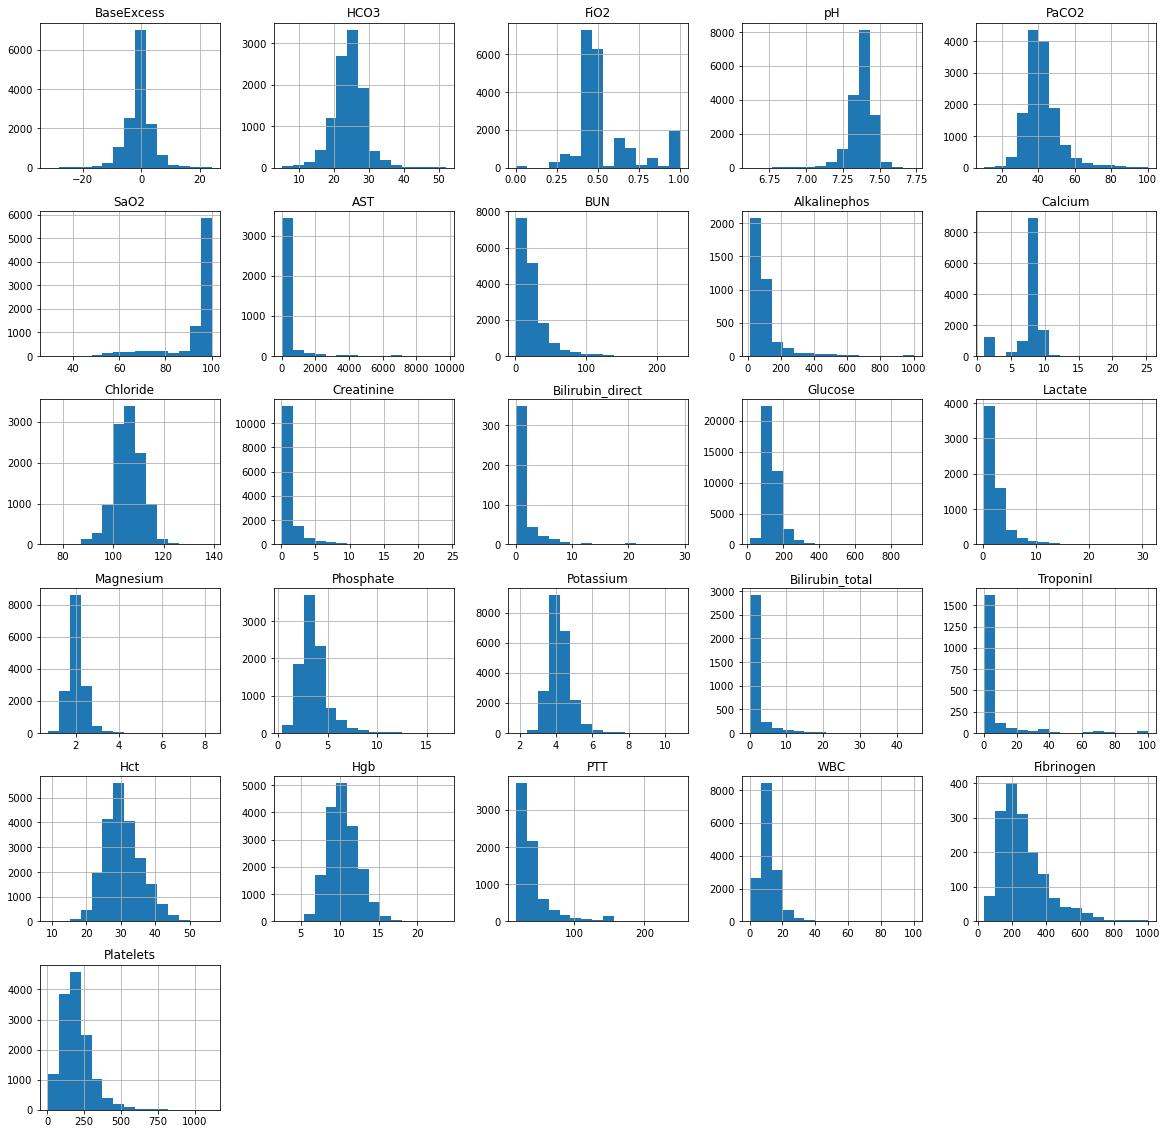

In [18]:
#Plot distributions for lab values
df.loc[:,"BaseExcess":"Platelets"].hist(figsize=(20,20),bins=15)
plt.show()

In [19]:
#Log trasnform the lab values that have skewed distributions
from sklearn.preprocessing import PowerTransformer

#Function to apply log transform to data 
def log_trans_columns(df,list_):
    for feature in list_:
        a=np.array(df[feature]).reshape(-1, 1)
        pow_trans = PowerTransformer()
        q=pow_trans.fit_transform(a)
        df[feature]=q
    return df

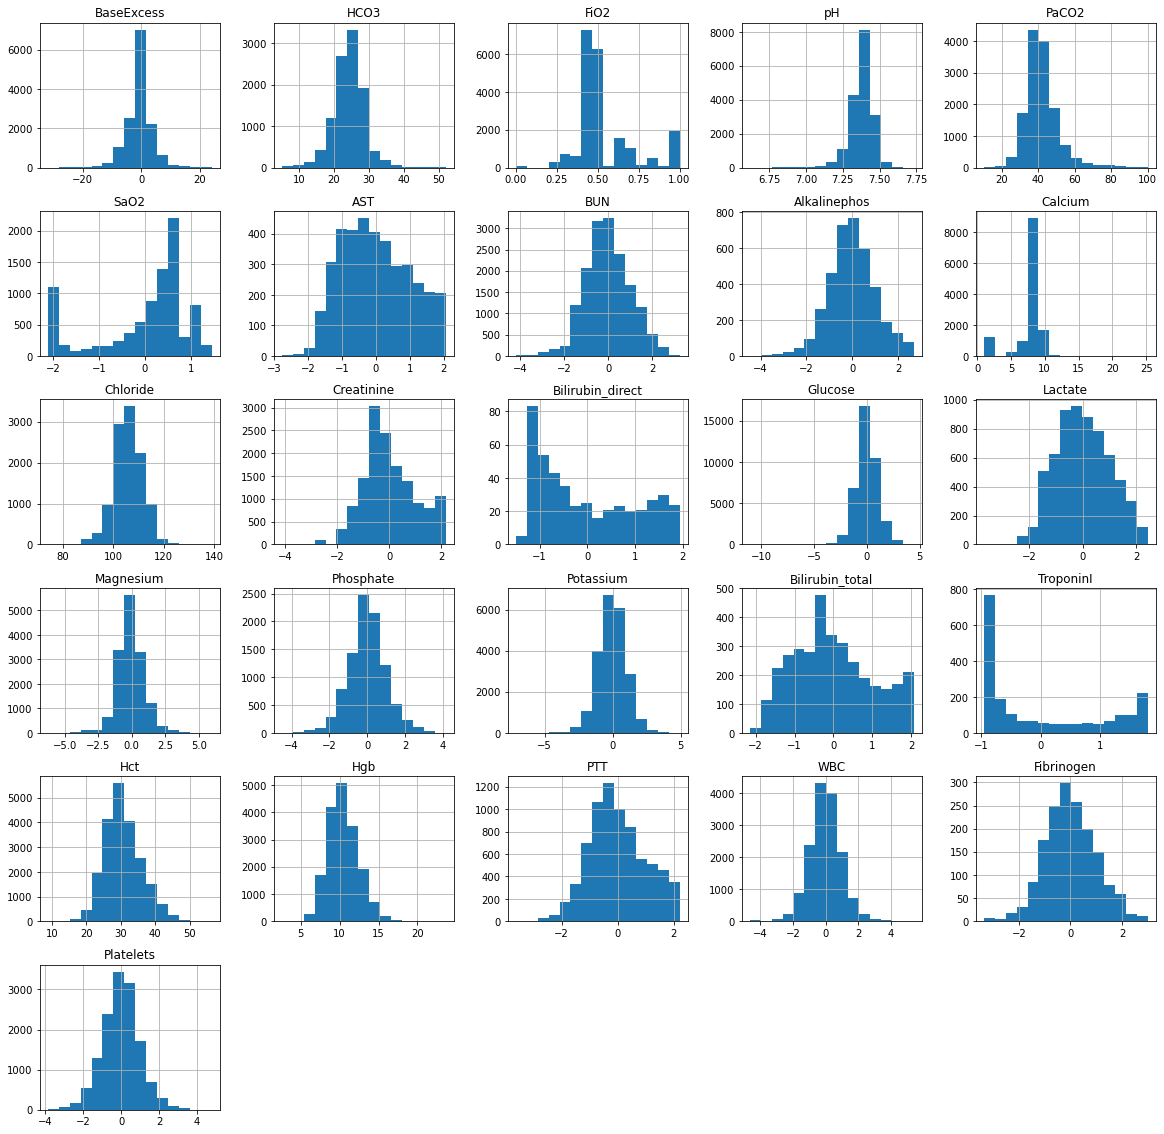

In [20]:
#Lab values with skewed looking distributions
columns=['AST', 'BUN','Alkalinephos','Creatinine', 'Bilirubin_direct','Glucose', 'Lactate', \
        'Magnesium','Phosphate', 'Potassium','Bilirubin_total','PTT', 'WBC', \
       'Fibrinogen', 'Platelets','TroponinI','SaO2']

#Apply transform & plot histogram
df=log_trans_columns(df,columns)
df.loc[:,"BaseExcess":"Platelets"].hist(figsize=(20,20),bins=15)
plt.show()

## Add Lab Indicator Column (Dummy)

In [21]:
#Start of code for creating lab indicator value

#Mark entries with a lab value as True
e=df.loc[:,'BaseExcess':'Platelets'].notnull()
df_lab_fill=pd.concat([df.id,e],axis=1)

In [22]:
from datetime import datetime

def lab_dummy(df):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    n=len(df.id.unique())
    s={}
    for feature in list(df.drop(columns='id').columns):
        i=0
        b=[]
        Subset=df[[feature,'id']]
        while i<=n:
            d=Subset.loc[df.id==i][feature].values
            len_=len(d)
            e=[]
            r=[]
            for val in d:
                if val==0:
                    e.append(0)
                    len_=len_-1
                else:
                    r=[1 for i in range(len_)]
                    break
            final=e+r
            b=b+final
            i=i+1
            s['Dum_'+ feature]=b
    return s

In [23]:
dict_=lab_dummy(df_lab_fill)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 16:41:29
Current Time = 16:44:39


In [24]:
#Forward fill missing lab values by patient
df=df.join(pd.DataFrame(dict_))
for feature in list(df.loc[:,'BaseExcess':'Platelets'].columns):
    df[feature]=df.groupby('id')[feature].fillna(method='ffill')
pd.set_option('display.max_rows', 2000)
df[0:1900]

d3_HR   d3_O2Sat   d3_Temp     d3_SBP      d3_MAP     d3_DBP  \
0      0.000000   0.000000  0.000000   0.000000    0.000000   0.000000   
1      0.000000   0.000000  0.000000   0.000000    0.000000   0.000000   
2      0.000000   0.000000  0.000000   0.000000    0.000000   0.000000   
3     -7.000000   0.000000  0.000000  24.000000   13.335000   0.000000   
4      6.000000  -6.500000  0.000000  24.000000   16.000000   0.000000   
5     21.000000  -8.000000  0.000000   0.500000   -1.835000   0.000000   
6     18.000000  -3.000000  0.000000   1.000000  -11.665000   0.000000   
7      3.000000   2.000000  0.265000 -29.000000  -15.000000   0.000000   
8     -6.000000   4.000000  0.530000  10.500000    4.165000   0.000000   
9     -6.000000  -1.000000  0.795000  11.000000   10.330000   0.000000   
10    -2.000000   1.500000  0.795000  45.000000   10.340000   0.000000   
11    -1.000000  -2.500000  0.408000   0.500000   -6.495000   0.000000   
12     0.000000   2.000000  0.021000  -5.000000  -10.330000   0.000000   
13     4.000000  -2.000000 -0.366000 -16.000000   10.000000   0.000000   
14     3.000000  -2.500000 -0.366000  -6.500000   14.835000   0.000000   
15     7.000000  -2.000000 -0.366000   3.000000   19.670000   0.000000   
16    -5.000000   0.000000 -0.106500  10.000000   -7.670000   0.000000   
17    -2.000000   2.000000  0.153000   5.000000  -15.340000   0.000000   
18    -2.500000   0.500000  0.412500   7.500000  -10.505000   0.000000   
19     6.000000   1.000000  0.412500  15.000000    2.000000   0.000000   
20     9.000000  -2.000000  0.165000   8.500000    5.835000   0.000000   
21    -8.500000   1.500000 -0.082500  -5.500000   -2.835000   0.000000   
22    -9.000000  -6.000000 -0.330000 -14.000000   -2.335000   0.000000   
23   -11.000000  -1.000000 -0.330000  -8.500000    6.835000   0.000000   
24    10.000000  -6.000000 -0.262500  15.000000    6.340000   0.000000   
25     7.000000   5.000000 -0.195000  23.000000    8.005000   0.000000   
26     2.000000   2.000000 -0.127500  36.000000   47.330000   0.000000   
27    -6.000000   1.000000 -0.127500  -3.000000    1.000000   0.000000   
28    -1.000000   1.000000  0.150000 -19.000000  -21.000000   0.000000   
29     8.000000  -2.000000  0.427500 -11.000000  -17.660000   0.000000   
30     7.500000   2.000000  0.705000   3.000000   19.665000   0.000000   
31     1.000000   0.000000  0.705000   4.000000   21.330000   0.000000   
32    -1.000000   1.500000  0.387500 -19.000000    2.330000   0.000000   
33    -5.500000   0.000000  0.070000 -23.000000    6.995000   0.000000   
34    -5.000000  -1.500000 -0.247500 -38.000000  -21.330000   0.000000   
35   -12.000000  -1.500000 -0.247500 -25.000000  -29.670000   0.000000   
36    -7.000000  -1.000000 -0.247500 -16.000000  -45.330000   0.000000   
37     8.000000  -0.500000 -0.247500   5.000000   15.000000   0.000000   
38     9.000000   0.000000 -0.247500  26.000000    6.000000   0.000000   
39    20.000000   2.000000 -0.247500  16.000000   32.670000   0.000000   
40    -3.000000   4.000000 -0.390000  18.000000    3.665000   0.000000   
41     9.000000   2.833333 -0.532500 -13.000000  -18.330000   0.000000   
42    -1.250000  -0.333333 -0.450000  15.750000   -2.085000   0.000000   
43     7.500000  -3.500000 -0.225000  31.500000   26.835000   0.000000   
44   -21.000000   3.166667  0.000000  -6.500000    3.500000   0.000000   
45   -31.750000   4.333333  0.000000 -30.250000  -34.755000   0.000000   
46   -28.500000   7.500000  0.000000 -30.500000  -44.840000   0.000000   
47     3.500000   1.000000  0.000000  24.000000    8.670000   0.000000   
48    16.000000  -8.500000  0.000000  69.500000   36.170000   0.000000   
49   -10.000000  -4.250000  0.000000 -42.000000  -23.330000   0.000000   
50   -18.500000   3.000000  0.000000 -44.500000  -45.170000   0.000000   
51   -15.000000  13.500000  0.000000 -78.000000  -56.000000   0.000000   
52    10.000000   0.250000  0.000000   2.000000   -9.000000   0.000000   
53     3.00000

In [25]:
#Print null value counts - many nulls for lab values
pd.DataFrame(df.isnull().sum().sort_values(ascending=False))

0
Bilirubin_direct      220576
Fibrinogen            205520
TroponinI             198053
Alkalinephos          162745
Bilirubin_total       162346
AST                   161819
Lactate               161019
SaO2                  159160
BaseExcess            151461
FiO2                  126461
PaCO2                 125518
HCO3                  123218
PTT                   123125
pH                    122128
Chloride              117844
Phosphate              97397
Calcium                68465
Magnesium              63472
WBC                    51431
Platelets              51041
Creatinine             49128
Hgb                    47981
BUN                    46898
Hct                    43742
Potassium              41746
Glucose                34325
d3_Resp                    0
d2_HR                      0
d3_EtCO2                   0
d2_EtCO2                   0
d3_DBP                     0
d2_Temp                    0
d3_MAP                     0
d3_SBP                     0
d3_Temp                    0
d3_O2Sat                   0
d2_O2Sat                   0
d2_SBP                     0
d1_HR                      0
HR                         0
d1_O2Sat                   0
d1_Temp                    0
d1_SBP                     0
d1_MAP                     0
d1_DBP                     0
d1_Resp                    0
d1_EtCO2                   0
O2Sat                      0
d2_MAP                     0
Temp                       0
MAP                        0
DBP                        0
Resp                       0
EtCO2                      0
d2_Resp                    0
d2_DBP                     0
SBP                        0
Dum_Platelets              0
Dum_Fibrinogen             0
Dum_Magnesium              0
Dum_Alkalinephos           0
Dum_Calcium                0
Dum_Chloride               0
Dum_Creatinine             0
Dum_Bilirubin_direct       0
Dum_Glucose                0
Dum_Lactate                0
Dum_Phosphate              0
Dum_AST                    0
Dum_Potassium              0
Dum_Bilirubin_total        0
Dum_TroponinI              0
Dum_Hct                    0
Dum_Hgb                    0
Dum_PTT                    0
Dum_WBC                    0
Dum_BUN                    0
Dum_SaO2                   0
Age                        0
HospitalA                  0
Gender                     0
Unit1                      0
Unit2                      0
HospAdmTime                0
ICULOS                     0
SepsisLabel                0
id                         0
SepsisOnset                0
Dum_PaCO2                  0
Hourly_Sepsis              0
Pre_Sepsis                 0
Pre_Acute_Sepsis           0
Dum_BaseExcess             0
Dum_HCO3                   0
Dum_FiO2                   0
Dum_pH                     0
d3_HR                      0

In [26]:
#Replace Remaining Nans with median
df.fillna(df.median(),inplace=True)

In [27]:
#Print out updated null value counts  - will be 0
pd.DataFrame(df.isnull().sum().sort_values())

0
d3_HR                 0
Pre_Sepsis            0
Hourly_Sepsis         0
SepsisOnset           0
HospitalA             0
id                    0
SepsisLabel           0
ICULOS                0
HospAdmTime           0
Unit2                 0
Pre_Acute_Sepsis      0
Unit1                 0
Age                   0
Platelets             0
Fibrinogen            0
WBC                   0
PTT                   0
Hgb                   0
Hct                   0
TroponinI             0
Bilirubin_total       0
Gender                0
Dum_BaseExcess        0
Dum_HCO3              0
Dum_FiO2              0
Dum_WBC               0
Dum_PTT               0
Dum_Hgb               0
Dum_Hct               0
Dum_TroponinI         0
Dum_Bilirubin_total   0
Dum_Potassium         0
Dum_Phosphate         0
Dum_Magnesium         0
Dum_Lactate           0
Dum_Glucose           0
Dum_Bilirubin_direct  0
Dum_Creatinine        0
Dum_Chloride          0
Dum_Calcium           0
Dum_Alkalinephos      0
Dum_BUN               0
Dum_AST               0
Dum_SaO2              0
Dum_PaCO2             0
Dum_pH                0
Potassium             0
Dum_Fibrinogen        0
Phosphate             0
Lactate               0
d1_MAP                0
d1_SBP                0
d1_Temp               0
d1_O2Sat              0
d1_HR                 0
d2_EtCO2              0
d2_Resp               0
d2_DBP                0
d2_MAP                0
d1_DBP                0
d2_SBP                0
d2_O2Sat              0
d2_HR                 0
d3_EtCO2              0
d3_Resp               0
d3_DBP                0
d3_MAP                0
d3_SBP                0
d3_Temp               0
d3_O2Sat              0
d2_Temp               0
d1_Resp               0
d1_EtCO2              0
HR                    0
Glucose               0
Bilirubin_direct      0
Creatinine            0
Chloride              0
Calcium               0
Alkalinephos          0
BUN                   0
AST                   0
SaO2                  0
PaCO2                 0
pH                    0
FiO2                  0
HCO3                  0
BaseExcess            0
EtCO2                 0
Resp                  0
DBP                   0
MAP                   0
SBP                   0
Temp                  0
O2Sat                 0
Magnesium             0
Dum_Platelets         0

# Save Data

In [28]:
#Save the data 
os.chdir("../processed")
pd.DataFrame.to_csv(df,'sepsis_data_preprocessed.csv')